In [1]:
import numpy as np
from preprocess import *
import pandas as pd

train_path = './essay_dataset/training_set_rel3.tsv'
training_data = load_training_set(train_path, 2)

glove_dict = load_dict('glove.840B.300d.pkl')

In [2]:
valid_path = './essay_dataset/valid_set.tsv'
valid_label_path = './essay_dataset/valid_sample_submission_2_column.csv'
valid_data = load_validation_set(valid_path, valid_label_path, 2)

In [3]:
training_data = process_scores(training_data, 'domain1_score')
valid_data = process_scores(valid_data, 'domain1_score')

In [4]:
from configs import cfg

cfg['input_dim'] = 301 # input dimension to LSTM
cfg['hidden_dim'] = 128 # hidden dimension for LSTM
cfg['output_dim'] = 1 # output dimension of the model
cfg['layers'] = 2 # number of layers of LSTM

cfg['dropout'] = 5e-2 # dropout rate between two layers of LSTM; useful only when layers > 1; between 0 and 1
cfg['bidirectional'] = True # True or False; True means using a bidirectional LSTM
cfg['batch_size'] = 120 # batch size of input
cfg['learning_rate'] = 1e-3 # learning rate to be used
cfg['L2_penalty'] = 1e-4 # weighting constant for L2 regularization term; this is a parameter when you define optimizer
cfg['epochs'] = 20 # number of epochs for which the model is trained
cfg['embed'] = False
cfg['score_range'] = 5

In [7]:
from dataloader import *
from models import *
import time

model = LSTM_Score(cfg, True)

#model = RNN(vocab_size=vocab_size, embed_size=args.embedding_size, num_output=10, rnn_model=args.rnn,
#            use_last=( not args.mean_seq),
#            hidden_size=args.hidden_size, embedding_tensor=embed, num_layers=args.layers, batch_first=True)
model = model.to(torch.device(cfg['device']))

criterion = nn.MSELoss()

#optimizer = torch.optim.RMSprop(model.parameters(), lr=cfg['learning_rate'], weight_decay=cfg['L2_penalty'])
optimizer = torch.optim.Adam(model.parameters(), lr=cfg['learning_rate'], weight_decay=cfg['L2_penalty'])
#optimizer = torch.optim.Adadelta(model.parameters(), lr=cfg['learning_rate'], weight_decay=cfg['L2_penalty'])

train_indices = list(range(len(training_data)))
valid_indices = list(range(len(valid_data)))

print('ready')

ready


In [8]:
model.train()

LSTM_Score(
  (embed_linear): Linear(in_features=301, out_features=301, bias=True)
  (lstm): LSTM(301, 128, num_layers=2, batch_first=True, dropout=0.05, bidirectional=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=1, bias=True)
)

In [9]:
train_losses = []
val_losses = []
for epoch in range(cfg['epochs']):
    tloader = DataLoader(training_data, train_indices, cfg, glove_dict)
    vloader = DataLoader(valid_data, valid_indices, cfg, glove_dict)
    
    count = 0
    avg_loss = 0
    while tloader.has_next():
        train, label, lengths = tloader.get_next()
        #print(train.size())
        #print(label.size())
        #print(lengths.size())
        model.zero_grad()
        
        y = model(train, lengths)      
        
        loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
        loss.backward()
        optimizer.step()

        count += 1
        avg_loss += loss.item()
        if count % 2 == 0:
            print("count = %d, loss = %.5f" %(count, avg_loss / 2))
            save_model(model, 'models/'+'s1_ba' +str(cfg['batch_size']) +'e' +  str(epoch + 1) + 'b' + str(count) + '.pt')
            train_losses.append(avg_loss/2)
            avg_loss = 0
        del train, label, y, loss
    
    count = 0
    avg_loss = 0
    with torch.no_grad():
        while vloader.has_next():
            train, label, lengths = vloader.get_next()
            y = model(train, lengths)
            loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
            count += 1
            avg_loss += loss.item()
            del train, label, y, loss
    print('validation loss:', avg_loss / count)
    print('epoch finished:', epoch + 1)
    val_losses.append(avg_loss/count)
    

count = 2, loss = 2.07545
count = 4, loss = 2.06772
count = 6, loss = 0.82046
count = 8, loss = 0.35912
count = 10, loss = 0.27037
count = 12, loss = 0.28470
count = 14, loss = 0.35865
validation loss: 0.21242425739765167
epoch finished: 1
count = 2, loss = 0.26439
count = 4, loss = 0.28953
count = 6, loss = 0.35698
count = 8, loss = 0.31285
count = 10, loss = 0.27919
count = 12, loss = 0.29402
count = 14, loss = 0.27148
validation loss: 0.22462601959705353
epoch finished: 2
count = 2, loss = 0.28122
count = 4, loss = 0.28757
count = 6, loss = 0.29421
count = 8, loss = 0.28232
count = 10, loss = 0.32485
count = 12, loss = 0.31197
count = 14, loss = 0.22721
validation loss: 0.23943398892879486
epoch finished: 3
count = 2, loss = 0.29404
count = 4, loss = 0.25618
count = 6, loss = 0.28978
count = 8, loss = 0.29381
count = 10, loss = 0.33144
count = 12, loss = 0.19858
count = 14, loss = 0.26711
validation loss: 0.22360673546791077
epoch finished: 4
count = 2, loss = 0.30306
count = 4, los

In [10]:
np.save('val_loss_set2_2.npy', val_losses)
np.save('train_loss_set2_2.npy', train_losses)

In [15]:
from evaluation import QWK_score

vloader = DataLoader(valid_data, valid_indices, cfg, glove_dict)
count = 0
avg_loss = 0
MAE = 0
targets = []
preds = []
with torch.no_grad():
    while vloader.has_next():
        train, label, lenghts = vloader.get_next()
        y = model(train, lenghts)
        #y = y.permute(0, 2, 1)
        #print(label - y)
        
        loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
        
        pred = np.round(y.cpu().numpy() * cfg['score_range'])
        target = np.round(label.cpu().numpy() * cfg['score_range'])

        pred = pred.flatten().astype(int)
        target = target.flatten().astype(int)
        
        targets.append(target)
        preds.append(pred)
        
        #print(target[0])
        #print(preds[0])
        
        count += 1
        avg_loss += loss.item()
        MAE += (y-label).abs().mean().item()
        
        del train, label, y, loss
        
print('validation MSE:', avg_loss / count)
print('validation MAE:', MAE / count)
print('QWK Score:', QWK_score(np.asarray(targets).flatten(), np.asarray(preds).flatten(), min_rating = 0, max_rating = cfg['score_range']))

validation MSE: 0.2503941416740417
validation MAE: 0.07970901429653168
QWK Score: 0.5885128150759362


In [11]:
np.round([0.1,0.5,0.4,0.51,0.8])

array([0., 0., 0., 1., 1.])

In [16]:
train_losses

[0.5860781818628311,
 0.458276629447937,
 0.17450132220983505,
 0.1616007462143898,
 0.119425218552351,
 0.10403617471456528,
 0.11544415727257729,
 0.12063881382346153,
 0.12936975806951523,
 0.1206429973244667,
 0.11869359761476517,
 0.08430387452244759,
 0.09124544262886047,
 0.09534449502825737,
 0.11391148716211319,
 0.1006905697286129,
 0.09873098507523537,
 0.1017775870859623,
 0.11640776321291924,
 0.09222627431154251,
 0.09164854511618614,
 0.08466239273548126,
 0.11262743547558784,
 0.10171670094132423,
 0.1051570288836956,
 0.09843045473098755,
 0.09505286067724228,
 0.1046961285173893,
 0.08478100225329399,
 0.1214694194495678,
 0.10686950758099556,
 0.08928555250167847,
 0.10787016153335571,
 0.09276992827653885,
 0.0936187207698822,
 0.10085402429103851,
 0.1043703593313694,
 0.08833080530166626,
 0.1005408950150013,
 0.09083717316389084,
 0.11326977983117104,
 0.09029350057244301,
 0.1094016395509243,
 0.0834839902818203,
 0.0785537138581276,
 0.09922155737876892,
 0.112

In [17]:
val_losses

[0.08470286279916764,
 0.0763450488448143,
 0.07914128452539444,
 0.07949087917804717,
 0.07911836504936218,
 0.08679685592651368,
 0.07654283344745635,
 0.08463973104953766,
 0.08020561188459396,
 0.08895530253648758,
 0.08239613696932793,
 0.08732239156961441,
 0.08221426010131835,
 0.0829360008239746,
 0.08056281358003617,
 0.08794207274913787,
 0.08339875042438508,
 0.0849191665649414,
 0.09260004609823227,
 0.09884261935949326]

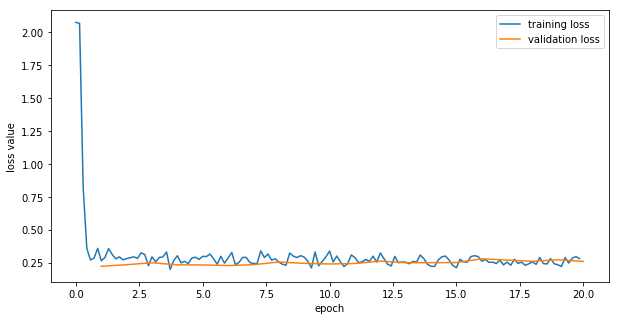

In [17]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.arange(len(train_losses)) / (len(train_losses) // len(val_losses)),train_losses,label='training loss')
ax.plot(np.arange(1,len(val_losses)+1) ,np.array(val_losses) + 0.01,label='validation loss')

ax.set_xlabel('epoch')
ax.set_ylabel('loss value')
ax.legend()
plt.show()

In [9]:
from dataloader import *
from models import *
model = load_model(LSTM_Score, './models_LSTM/eba117b1400.pt', cfg)
valid_indices = list(range(len(valid_data)))

RuntimeError: Error(s) in loading state_dict for LSTM_Score:
	Missing key(s) in state_dict: "bn.weight", "bn.bias", "bn.running_mean", "bn.running_var". 
	Unexpected key(s) in state_dict: "conv.weight", "conv.bias", "fc2.weight", "fc2.bias". 
	While copying the parameter named "fc1.weight", whose dimensions in the model are torch.Size([1, 256]) and whose dimensions in the checkpoint are torch.Size([64, 256]).
	While copying the parameter named "fc1.bias", whose dimensions in the model are torch.Size([1]) and whose dimensions in the checkpoint are torch.Size([64]).

In [13]:
val_losses

[1.47348153591156,
 0.6406370401382446,
 0.39495953917503357,
 0.32788610458374023,
 0.46300799399614334,
 0.4477241486310959,
 0.38527511805295944,
 0.40745867043733597,
 0.4503869116306305,
 0.4217817857861519,
 0.3887465298175812,
 0.3928548991680145,
 0.42445058375597,
 0.48021963983774185,
 0.47371671348810196,
 0.412605918943882,
 0.4933035224676132,
 0.4228593334555626,
 0.49359291046857834,
 0.5352080911397934]

In [14]:
train_losses

[7.9363625049591064,
 8.973733901977539,
 4.763446807861328,
 3.0619534254074097,
 2.584040403366089,
 2.0441386699676514,
 2.1084685921669006,
 1.6885703206062317,
 1.531571865081787,
 1.6946741938591003,
 1.2110268473625183,
 1.3063259720802307,
 0.9987798631191254,
 0.8282113969326019,
 0.9221987426280975,
 0.9459511041641235,
 0.7851526439189911,
 0.8722099363803864,
 0.6612995564937592,
 0.6654603481292725,
 0.7896145582199097,
 0.8583588898181915,
 0.6742445528507233,
 0.8870276510715485,
 0.6685461401939392,
 0.6565273702144623,
 0.5628261119127274,
 0.6644041836261749,
 0.6435962915420532,
 0.5441005229949951,
 0.7773476541042328,
 0.8098107278347015,
 0.7732094526290894,
 0.6991858780384064,
 0.7715423703193665,
 0.6842981576919556,
 0.735701322555542,
 0.6935223042964935,
 0.5725542902946472,
 0.8133407831192017,
 0.6434799432754517,
 0.7053241729736328,
 0.7483589947223663,
 0.7538842856884003,
 0.5727023184299469,
 0.5533912777900696,
 0.7172544598579407,
 0.793199896812439